# SERS spectra classification 

In [1]:
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from sklearn.utils import shuffle
from boxsers import data_split
from boxsers.visual_tools import distribution_plot, spectro_plot
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, cosmic_filter, spectral_cut
from boxsers.data_augmentation import aug_noise, aug_mixup, aug_linslope, aug_xshift
from boxsers import SpectroCNN
from boxsers.machine_learning import SpectroLDA, SpectroRF, SpectroSVM, SpectroCNN, validation_metrics

import matplotlib.pyplot as plt
import numpy as np

2025-07-31 18:01:18.392434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 18:01:18.392469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 18:01:18.393319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### 讀取ASTII 資料集的所有抗藥性資料

In [2]:
df = pd.read_csv('./data_astii/ASTII_filter_all_patient_med.csv')  

display(df)  # Prints a detailed overview of the imported dataframe "df"

# Features extraction: Exports dataframe spectra as a numpy array (value type = float64).
sp = df.iloc[:, 2:].to_numpy()
# Labels extraction: Export dataframe classes into a numpy array of string values.
label = df.loc[:, 'Classes'].values


,Classes,Patient_ID,0,1,2,3,4,5,6,7,...,390,391,392,393,394,395,396,397,398,399
0,CR K. pneumonia,GN080,4157.5503,4171.8086,4167.3413,4165.9727,4172.4214,4166.2580,4164.8726,4179.4263,...,3225.5205,3211.1104,3219.3699,3202.6970,3198.4922,3165.7056,3179.1060,3147.3013,3149.6660,3146.8872
1,CR K. pneumonia,GN080,3673.8274,3681.4200,3692.8657,3678.9944,3696.6140,3665.5413,3675.6826,3683.8364,...,3102.9736,3109.3674,3085.9860,3083.9610,3093.5420,3070.3025,3082.5625,3082.2834,3057.8914,3051.3250
2,CR K. pneumonia,GN080,4129.1640,4124.7730,4112.5938,4134.5820,4139.1680,4120.1650,4138.4280,4152.0557,...,3201.8600,3194.9220,3176.0620,3175.0130,3166.3657,3157.4692,3170.8647,3148.8250,3122.2522,3104.6433
3,CR K. pneumonia,GN080,4252.8710,4246.3896,4232.0503,4236.5215,4242.6480,4255.5540,4232.9550,4253.7450,...,3461.2566,3460.3855,3451.7302,3465.3313,3446.9524,3442.7970,3423.1220,3408.1006,3400.3916,3390.7693
4,CR K. pneumonia,GN080,3403.8699,3399.3940,3402.9350,3400.4922,3422.9065,3413.7498,3416.4478,3429.5107,...,2656.8650,2669.4070,2677.3572,2666.1410,2673.8284,2671.1810,2678.0466,2640.8180,2623.4736,2633.0770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8610,CR E. cloacae,GN112,6404.6250,6393.5530,6394.5938,6389.1885,6420.7354,6408.1743,6417.1406,6452.9917,...,5265.3833,5266.2070,5217.6953,5214.3853,5235.0990,5191.2007,5188.7417,5140.2920,5153.2820,5144.0300
8611,CR E. cloacae,GN112,5737.5440,5750.7280,5728.0950,5753.3237,5779.1465,5794.3400,5783.1160,5779.5874,...,4757.7870,4791.1357,4768.2790,4760.8840,4754.3926,4720.5845,4727.5757,4711.5670,4701.3470,4669.8370
8612,CR E. cloacae,GN112,6721.3755,6715.3770,6724.0938,6724.7173,6755.7460,6787.1875,6790.4854,6793.0254,...,5245.0522,5283.5464,5265.9663,5224.5190,5218.6084,5227.2793,5189.4390,5199.2188,5185.1410,5101.2715
8613,CR E. cloacae,GN112,6639.9634,6645.4470,6666.8950,6681.9660,6631.7344,6633.6406,6641.3670,6669.2407,...,5581.0790,5560.7837,5554.0720,5514.1530,5522.5693,5526.2383,5501.3867,5456.2803,5453.7295,5455.7026


#### 讀取ASTII資料集的IPM (Imipenem)標記的病患標籤表

In [3]:
ipm_astii = pd.read_csv('./ASTII_IPM_TOTAL.csv', header = 0) 
display(ipm_astii)

,No.,菌名,IPM (Imipenem)
0,GN067,E. coli,S
1,GN068,E. coli,S
2,GN069,E. coli,S
3,GN070,E. coli,S
4,GN082,E. coli,S
5,GN084,E. coli,S
6,GN085,E. coli,S
7,GN086,E. coli,S
8,GN088,E. coli,S
9,GN105,E. coli,S


#### 將含有藥物資訊的 ASTII_IPM_TOTAL.csv 檔案與原始 SERS 資料 df 按照病患編號（No. 和 Patient_ID）做配對，找出有光譜資料又有藥物資訊的病患，整合成一個新的資料表 

In [4]:
merged_data_astii = ipm_astii.merge(df, left_on="No.", right_on="Patient_ID", how="inner")


#### 將 類別是 E. coli 的資料抓出來

In [5]:
merged_data_astii_new = merged_data_astii[merged_data_astii['Classes'] == 'CR E. coli']

#### 資料前處理

In [6]:
def preprocessing_method(x):
    # 1) Applies a median filter to remove cosmic rays from the spectrum(s).
    x = cosmic_filter(x, ks=3)
    # 2) Smoothes the spectra
    x = savgol_smoothing(x, 7, p=3, degree=0)
    # 3) Subtracts the baseline signal from the spectrum(s) using Asymmetric Least Squares estimation.
    x = als_baseline_cor(x, lam=1e4, p=0.001)
    # 3) Normalizes the spectra 
    x = spectral_normalization(x, norm='l2')
    return x


merged_data_astii_new = merged_data_astii_new.copy()
# 預處理光譜數據
sp_p = merged_data_astii_new.iloc[:, 5:].to_numpy()
merged_data_astii_new.loc[:, merged_data_astii_new.columns[5:]] = preprocessing_method(sp_p)


In [7]:
label_mapping = {
    'I': 0,
    'R':0,
    'S': 1
    
}

# 打印出數字標籤對應的類別
for label_num, class_name in label_mapping.items():
    print(f"數字標籤 {label_num}: {class_name}")
    
merged_data_astii_new = merged_data_astii_new.copy()
merged_data_astii_new["IPM (Imipenem)"] = merged_data_astii_new["IPM (Imipenem)"].map(label_mapping)

# 將數字標籤和其餘的數據分開
labels = merged_data_astii_new["IPM (Imipenem)"].values
Patient_ID = merged_data_astii_new['Patient_ID'] 
features = sp_p 

數字標籤 I: 0
數字標籤 R: 0
數字標籤 S: 1


In [8]:
# 儲存數字標籤和特徵為 .npy 檔案
np.save('./data_astii/y_astii_filter_ipm._ecoli.npy', labels)
np.save('./data_astii/X_astii_filter_ipm_ecoli_norm.npy', features)
np.save('./data_astii/patient_astii_filter_ipm_ecoli.npy',Patient_ID )
print("數字標籤和特徵已成功存為 .npy 檔案。")

數字標籤和特徵已成功存為 .npy 檔案。


#### 讀取 ASTIII 資料集的所有抗藥性資料

In [9]:
df_astiii = pd.read_csv('./data_astii/ASTIII_filter_all_med.csv', header = 0)  # Load bile acids dataframe

display(df_astiii)

,Classes,Patient_ID,0,1,2,3,4,5,6,7,...,390,391,392,393,394,395,396,397,398,399
0,CR K. pneumonia,X012,8747.507,8778.6500,8748.9160,8759.6380,8767.1630,8761.2220,8741.6250,8720.3125,...,8124.3230,8104.3696,8061.9385,8041.9170,8054.3584,8005.9224,8051.4966,7990.5713,7973.3240,7974.9710
1,CR K. pneumonia,X012,8100.952,8075.8420,8041.8506,8053.6743,8069.3210,8037.3413,8025.4873,8049.4900,...,6225.0728,6229.8830,6197.5117,6183.6997,6165.6970,6169.9336,6151.6380,6113.0270,6107.5620,6101.3237
2,CR K. pneumonia,X012,11089.164,11036.3330,11047.2410,11024.1455,10990.7330,10970.6680,10962.0180,10955.2320,...,8222.2480,8207.4210,8166.3170,8165.2480,8149.0825,8129.7950,8094.0740,8081.4810,8041.2134,7998.3413
3,CR K. pneumonia,X012,6806.441,6782.8394,6779.2910,6772.5684,6781.7876,6778.2060,6739.0060,6752.5730,...,5275.9540,5277.4400,5239.2983,5212.0000,5210.9110,5216.1820,5224.8643,5204.9736,5184.9330,5155.1250
4,CR K. pneumonia,X012,8766.871,8811.5580,8780.0960,8789.7100,8756.7310,8748.5290,8763.3880,8787.3260,...,7307.9530,7257.7560,7262.8830,7272.2383,7245.7630,7273.8257,7226.4240,7185.5570,7163.7197,7142.6910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,CR E. cloacae,X170,22156.775,22088.9600,22249.4450,22254.6780,22118.3790,22055.9470,22186.8630,22266.2380,...,24206.3220,24079.7250,24104.5400,24176.0490,24138.6430,24043.0370,23996.7090,23965.1450,23782.1150,23759.1210
8893,CR E. cloacae,X170,21703.090,21760.3340,21722.8570,21755.4790,21814.1800,21795.2910,21803.5620,21866.2010,...,26338.4960,26224.1900,26232.5880,26265.1290,26218.0490,26247.6050,26220.4380,26106.4570,26007.2560,26027.3610
8894,CR E. cloacae,X170,18076.744,17954.7500,18008.3400,18125.3960,18102.2320,18026.9000,18065.3260,18156.0820,...,21595.8220,21538.0860,21660.2750,21561.7230,21458.6720,21627.4280,21629.2520,21374.4140,21418.3360,21347.9790
8895,CR E. cloacae,X170,24179.152,24268.3050,24210.7710,24253.5400,24279.1250,24219.8050,24233.4770,24375.3200,...,27557.1250,27551.4400,27578.5370,27502.4060,27454.8520,27507.2700,27488.5020,27318.3300,27285.9080,27137.0980


#### 讀取ASTII資料集的IPM (Imipenem)標記的病患標籤表

In [10]:
ipm_astiii = pd.read_csv('./ASTIII_IPM_TOTAL.csv', header = 0)  # Load bile acids dataframe

display(ipm_astiii)

,No.,菌名,IPM (Imipenem)
0,X009,Escherichia coli,S
1,X010,Enterobacter cloacae complex,S
2,X011,Klebsiella pneumoniae,S
3,X012,Klebsiella pneumoniae,S
4,X013,Escherichia coli,S
...,...,...,...
67,X227,Escherichia coli,S
68,X229,Klebsiella pneumoniae,S
69,X230,Escherichia coli,S
70,X232,Klebsiella pneumoniae,R


#### 將含有藥物資訊的 ASTIII_IPM_TOTAL.csv 檔案與原始 SERS 資料 df_astiii 按照病患編號（No. 和 Patient_ID）做配對，找出有光譜資料又有藥物資訊的病患，整合成一個新的資料表 

In [11]:
merged_data_astiii = ipm_astiii.merge(df_astiii, left_on="No.", right_on="Patient_ID", how="inner")

#### 將 類別是 E. coli 的資料抓出來

In [12]:
merged_data_astiii_new = merged_data_astiii[merged_data_astiii['Classes'] == 'CR E. coli']

#### 資料前處理

In [13]:
def preprocessing_method(x):
    # 1) Applies a median filter to remove cosmic rays from the spectrum(s).
    x = cosmic_filter(x, ks=3)
    # 2) Smoothes the spectra
    x = savgol_smoothing(x, 7, p=3, degree=0)
    # 3) Subtracts the baseline signal from the spectrum(s) using Asymmetric Least Squares estimation.
    x = als_baseline_cor(x, lam=1e4, p=0.001)
    # 3) Normalizes the spectra 
    x = spectral_normalization(x, norm='l2')
    return x

merged_data_astiii_new = merged_data_astiii_new.copy()

# 預處理光譜數據
sp_p = merged_data_astiii_new.iloc[:, 5:].to_numpy()
merged_data_astiii_new.loc[:, merged_data_astiii_new.columns[5:]] = preprocessing_method(sp_p)

In [14]:
label_mapping = {
    'I': 0,
    'R':0,
    'S': 1
    
}

# 打印出數字標籤對應的類別
for label_num, class_name in label_mapping.items():
    print(f"數字標籤 {label_num}: {class_name}")
merged_data_astiii_new = merged_data_astiii_new.copy()
merged_data_astiii_new[merged_data_astiii_new.columns[2]] = merged_data_astiii_new[merged_data_astiii_new.columns[2]].map(label_mapping)

# 將數字標籤和其餘的數據分開
labels = merged_data_astiii_new[merged_data_astiii_new.columns[2]].values
Patient_ID = merged_data_astiii_new['Patient_ID'] 
features = sp_p # 取出除了 'Classes' 以外的所有欄位

數字標籤 I: 0
數字標籤 R: 0
數字標籤 S: 1


In [15]:
# 儲存數字標籤和特徵為 .npy 檔案
np.save('./data_astii/y_filter_all_astiii_ipm_ecoli.npy', labels)
np.save('./data_astii/X_filter_all_astiii_ipm_ecoli_norm.npy', features)
np.save('./data_astii/patient_filter_all_astiii_ipm_ecoli.npy', Patient_ID)

print("數字標籤和特徵已成功存為 .npy 檔案。")

數字標籤和特徵已成功存為 .npy 檔案。


#### 將ASTII與ASTIII資料集的E. coli資料合併

In [16]:
combined_data = np.concatenate((merged_data_astii_new, merged_data_astiii_new), axis=0)
combined_data 

array([['GN067', 'E. coli', 1, ..., 0.01578613514498043,
        0.015426138179757166, 0.017920847137494426],
       ['GN067', 'E. coli', 1, ..., 0.026733874565216403,
        0.026023902929680914, 0.021815192275189285],
       ['GN067', 'E. coli', 1, ..., 0.013495233587013211,
        0.01271585846501219, 0.011724954620761913],
       ...,
       ['X230', 'Escherichia coli', 1, ..., 0.018864107548064495,
        0.017075244002620563, 0.013199906086372405],
       ['X230', 'Escherichia coli', 1, ..., 0.010542423059723485,
        0.009599770054393855, 0.00838684365806893],
       ['X230', 'Escherichia coli', 1, ..., 0.02156499629307683,
        0.022460405446988407, 0.02451091247506005]], dtype=object)

In [17]:
sp_p = combined_data[:,5:]
sp_p = sp_p.astype(np.float64)
output_file = './data_astii/combine_astii_astiii_filter_all_smoothing_ipm_ecoli_norm.npy'
np.save(output_file, sp_p)

In [18]:
labels = combined_data[:,2]
output_file = './data_astii/y_astii_astiii_filter_all_ipm_ecoli.npy'
np.save(output_file, labels)

In [19]:
Patient_ID = combined_data[:,0]
output_file = './data_astii/patient_astii_astiii_filter_all_ipm_ecoli.npy'
np.save(output_file, Patient_ID)

#### 繪製光譜圖

In [20]:
classnames=['CR E.coli', 'CS E.coli']

In [21]:
def _lightdark_switch(darktheme):

    if darktheme:
        return 'w', 'k', 0.3  # the grid is slightly paled for the dark theme
    return 'k', 'w', 0.4

def spectro_plot_avg_std(wn, sp, labels, target_label, colors=None, xlim=None, ylim=None, title=None, 
                         xlabel='Raman Shift (cm$^{-1}$)', ylabel='Intensity (a.u.)', 
                         line_width=1.5, darktheme=False, 
                         grid=True, fontsize=10, fig_width=6.08, fig_height=3.8, save_path=None):

    # Update theme parameters
    frame_color, bg_color, alpha_value = _lightdark_switch(darktheme)

    # Filter spectra by the target label
    class_spectra = sp[labels == target_label]

    # Check if class_spectra is not empty
    if class_spectra.size == 0:
        raise ValueError(f"No spectra found for target label {target_label}. Check your data or target label.")

    # Ensure class_spectra is a 2D array
    if class_spectra.ndim == 1:
        class_spectra = np.expand_dims(class_spectra, axis=0)

    # Ensure the data is numeric
    if not np.issubdtype(class_spectra.dtype, np.number):
        raise TypeError("class_spectra contains non-numeric data. Check your input.")

    # Calculate average and standard deviation
    avg_spectrum = np.mean(class_spectra, axis=0)
    std_spectrum = np.std(class_spectra, axis=0)

    
    label_name = classnames[target_label]
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.plot(wn, avg_spectrum, color=colors, lw=line_width, label=f'Class {label_name} Avg Spectrum')
    ax.fill_between(wn, avg_spectrum - std_spectrum, avg_spectrum + std_spectrum, color=colors, alpha=0.2, label='± Standard Deviation')

    # Set axis limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Titles and labels
    ax.set_title(title, fontsize=fontsize + 2, color=frame_color)
    ax.set_xlabel(xlabel, fontsize=fontsize, color=frame_color)
    ax.set_ylabel(ylabel, fontsize=fontsize, color=frame_color)

    # Customize ticks and spines
    ax.tick_params(axis='both', which='major', labelsize=fontsize - 2, color=frame_color)
    ax.tick_params(axis='both', which='minor', color=frame_color)
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_color(frame_color)

    # Add grid if enabled
    if grid:
        ax.grid(alpha=alpha_value)

    # Add legend for the class
    ax.legend(fontsize=fontsize - 2, facecolor=bg_color, labelcolor=frame_color)

    # Set figure and axes background colors
    fig.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)

    # Adjust layout
    fig.tight_layout()

    # Save plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()



In [22]:
# Normalize each spectrum
start_wavenumber = 404
end_wavenumber = 2000
target_wavenumbers = np.arange(start_wavenumber, end_wavenumber+1, 4)

wn = target_wavenumbers 
wn_p = target_wavenumbers 

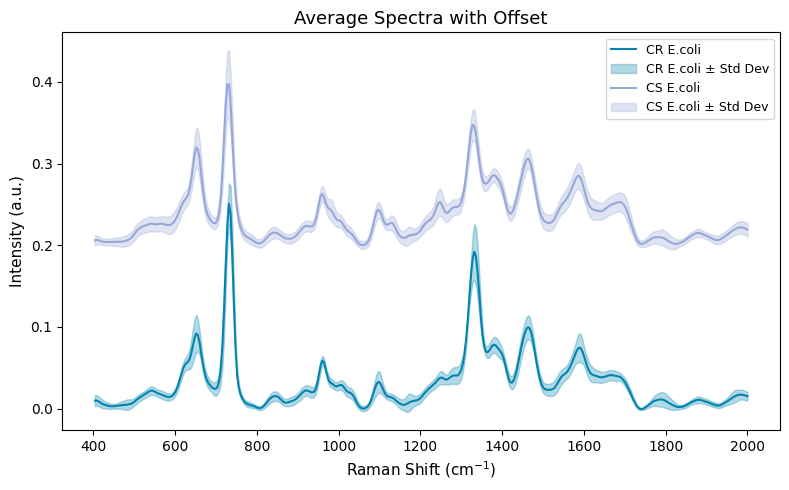

In [23]:
import matplotlib.pyplot as plt
import numpy as np


# Define label-color pairs for plotting
label_color_pairs = [
    (0, "#0384AF"),  # DeepSkyBlue
    (1, "#97A7D8"),
]

# Offset value for label=1
offset = 0.2

# Create figure
fig, ax = plt.subplots(figsize=(8, 5))

# Iterate and plot
for label, color in label_color_pairs:
    # Filter data and compute mean and std
    class_spectra = sp_p[labels == label]
    avg_spectrum = np.mean(class_spectra, axis=0)
    std_spectrum = np.std(class_spectra, axis=0)

    # Apply offset only to label=1
    if label == 1:
        avg_spectrum = avg_spectrum + offset

    label_name = classnames[label]

    # Plot line
    ax.plot(
        wn_p,
        avg_spectrum,
        color=color,
        lw=1.5,
        label=f'{label_name}'
    )

    # Plot fill between
    ax.fill_between(
        wn_p,
        avg_spectrum - std_spectrum,
        avg_spectrum + std_spectrum,
        color=color,
        alpha=0.3,
        label=f'{label_name} ± Std Dev'
    )

# Labels and title
ax.set_xlabel('Raman Shift (cm$^{-1}$)', fontsize=11)
ax.set_ylabel('Intensity (a.u.)', fontsize=11)
ax.set_title('Average Spectra with Offset', fontsize=13)
ax.legend(fontsize=9)

# Layout
plt.tight_layout()
plt.show()
